In [1]:
import mysql.connector 
import config_aws
import requests
# import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
# import string # For the remove_special_chars function
import pandas as pd
from sodapy import Socrata
import sqlalchemy as db
import pandas as pd
# from helpers import (query, query_list)

In [27]:
#instantiate the connection and table

engine = db.create_engine(f'mysql+mysqlconnector://{config_aws.user}:{config_aws.pw}@{config_aws.host}/building_permits')

connection = engine.connect()
metadata=db.MetaData()

In [28]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

**Whitelist only the necessary columns:**

Dependent Variable:
- residential (Y, N)

Categorical:
- self_cert (Y, N, NA)
- zip_code - DROP
- borough (2)
- community_board (36)
- nonprofit (Y, N) likely correlated
- work_type (12 - categorized) now 'cat_work_type'
- job_type (A2, A3, A1, NB, DM, SG)
- permit_type (EW, PL, EQ, AL, NB, FO, SG, DM) # going to be correlated with job_type!
- permittee_liscense_type (GC, MP, FS, OB, SI, NW, OW, RA, PE)
- cat_owner_business_type  
- gis_nta_name (80 different location names, neighborhoods) DROP???
- owner_s_zip_code (2305 total values) - DROP?
- permit_sequence__ (29 options, number of a sequence type)
- gis_council_district (26 options)
- gis_census_tract (861 options) - DROP

-permit_status (NO)

Continuous:
- time_to_issuance (from filing_date, issuance_date)
- time_to_startdate (from job_start_date, issuance_date)

In [29]:
# raw_data = query('SELECT self_cert, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough, issuance_date, filing_date FROM building_permits.dob_permits WHERE dob_permits.borough = "MANHATTAN"')

In [30]:
raw_data = query('SELECT self_cert, non_profit, residential, job_type, work_type, gis_council_district, permittee_s_license_type, borough FROM building_permits.nyc_permits')

In [31]:
raw_data.head()

,self_cert,non_profit,residential,job_type,work_type,gis_council_district,permittee_s_license_type,borough
0,Y,N,No,NB,PL,22,MP,QUEENS
1,N,N,YES,A3,OT,29,GC,QUEENS
2,N,N,No,A2,SP,2,FS,MANHATTAN
3,Y,N,No,NB,NA,22,GC,QUEENS
4,Y,Y,No,A2,OT,7,GC,MANHATTAN


In [32]:
def cat_work(x):
    if x == 'OT':
        return 'Other'
    elif x == 'PL':
        return 'Plumbing'
    elif x == 'EQ':
        return 'Eqipment'
    elif x == 'NA':
        return 'Other'
    elif x == 'MH':
        return 'Mech'     
    elif x == 'SP':
        return 'Internal'
    elif x == 'BL':
        return 'Internal'
    elif x =='SD':    
        return 'External'
    elif x == 'FP':   #all 6 are fuel related
        return 'Fuel'
    elif x == 'FB': 
        return 'Fuel'
    elif x == 'FS':    
        return 'Fuel'
    elif x == 'CC':
        return 'External'
    else:
        return 'Other'



Data was too disproportionate to measure filing rate even when converted to binary

In [ ]:
# def filing_rate(x):
#     if x == '0':
#         return 'Immediate'
#     elif x >= '1' and x >= '10000':
#         return 'Delay'

# raw_data['time_to_issuance']=raw_data['issuance_date'] - raw_data['filing_date']

# raw_data['time_to_issuance'] = raw_data['time_to_issuance'].map(lambda x: x.strip(' days'))

    
# data['issuance_rate'] = data['time_to_issuance'].map(lambda x: filing_rate(x))
# filing_rate(df[''])

Had to drop ob_type because of data leakage!

In [ ]:
# def ob_type_categorize(x):
#     if x == "CORPORATION":
#         return 'Corp'
#     if x == 'INDIVIDUAL':
#         return 'Individual'
#     if x == "CONDO/CO-OP":
#         return 'Individual'
#     if x == "OTHER GOV'T AGENCY":
#         return 'Government'
#     if x == "NYCHA/HHC":
#         return 'Government'
#     if x == "NYC AGENCY":
#         return 'Government'
#     if x == "NYCHA":
#         return 'Government'
#     if x == "HPD":
#         return 'Government'
#     if x == "DOE":
#         return 'Government'
#     if x == "HHC":
#         return 'Government'
#     if x == "DCAS":
#         return 'Government'
#     if x == "NY STATE":
#         return 'Government'
#     if x == "PARTNERSHIP":
#         return 'Part_Other'
#     if x == "OTHER":
#         return 'Part_Other'
#     else:
#         return 'Part_Other'
   

In [ ]:
# def full_clean(data):
    
#     #create new column 
# #     data['time_to_issuance']=data['issuance_date'] - data['filing_date']
    
# #     data['issuance_rate'] = data['time_to_issuance'].map(lambda x: filing_rate(x))
    
#     #create new column
# #     data['cat_owner_business_type'] = data['owner_s_business_type'].map(lambda x: ob_type_categorize(x))
    
#     data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
     
    
#     data.drop(columns=['work_type'], inplace=True)
    
#     #create new column for 
# #     data['time_to_startdate'] = data['issuance_date'] - data['job_start_date']
    
#     return data

In [33]:
def final_clean(data):
     
    data['cat_work_type'] = data['work_type'].map(lambda x: cat_work(x))
         
    data.drop(columns=['work_type'], inplace=True)
     
    return data

In [34]:
final = final_clean(raw_data)

In [35]:
# df =raw_data
final.head()
final.shape


(1678580, 8)

In [45]:
df = final.sample(n=10000, random_state=1)
df.shape

(10000, 8)

In [46]:
#drop dependent variable
y = df['residential']
X = df.drop(columns='residential', axis=1)
# X.head()

**Train Test Split**

In [47]:
#train test split
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [48]:
X_train.shape

(8000, 7)

In [49]:
X_test.shape

(2000, 7)

**DummyClassifier** is a classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

In [14]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [15]:
dummy.score(X_test, y_test)  

0.5377342753994447

**One Hot Encode**

In [22]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [50]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
# ohe.fit(X_test)
X_train_ohe = ohe.transform(X_train).toarray()
# X_test_ohe = ohe.transform(X_test).toarray()

# Show:
# ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
# ohe_df.head()

In [51]:
#One-hot encode the training data
ohe = OneHotEncoder(drop='first')

ohe.fit(X_test)
X_test_ohe = ohe.transform(X_test).toarray()

# Show:
# ohe_df = pd.DataFrame(X_train_ohe, columns=ohe2.get_feature_names(X_train.columns))
# ohe_df.head()

In [22]:
#get column names from the dataframe
# col_names = ohe_df.columns

In [52]:
X_train_ohe.shape

(8000, 75)

In [53]:
X_test_ohe.shape

(2000, 75)

**Decision Tree**

In [31]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='gini', max_depth = 5)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

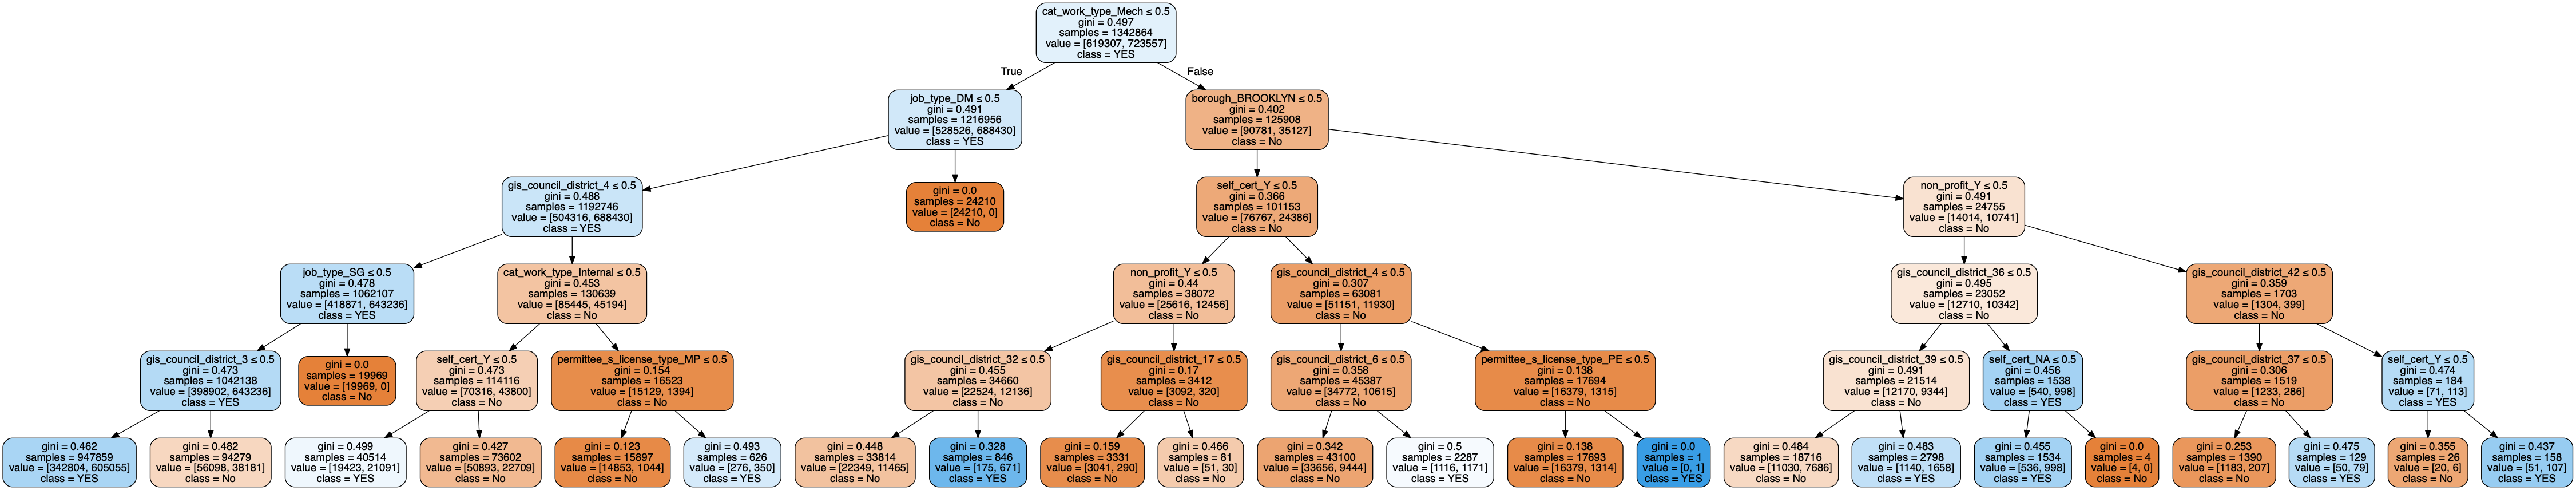

In [32]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

# graph
graph = graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [33]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.6575140892897569


In [80]:
clf.feature_importances_

array([3.99743971e-05, 0.00000000e+00, 3.86298765e-02, 6.55721550e-03,
       0.00000000e+00, 0.00000000e+00, 1.87125969e-01, 0.00000000e+00,
       1.76703862e-01, 0.00000000e+00, 1.10542176e-01, 1.93368491e-01,
       0.00000000e+00, 4.41074044e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.50250258e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.02858257e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.56444715e-03,
       6.00282206e-04, 0.00000000e+00, 1.90657736e-03, 0.00000000e+00,
       0.00000000e+00, 7.04553673e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

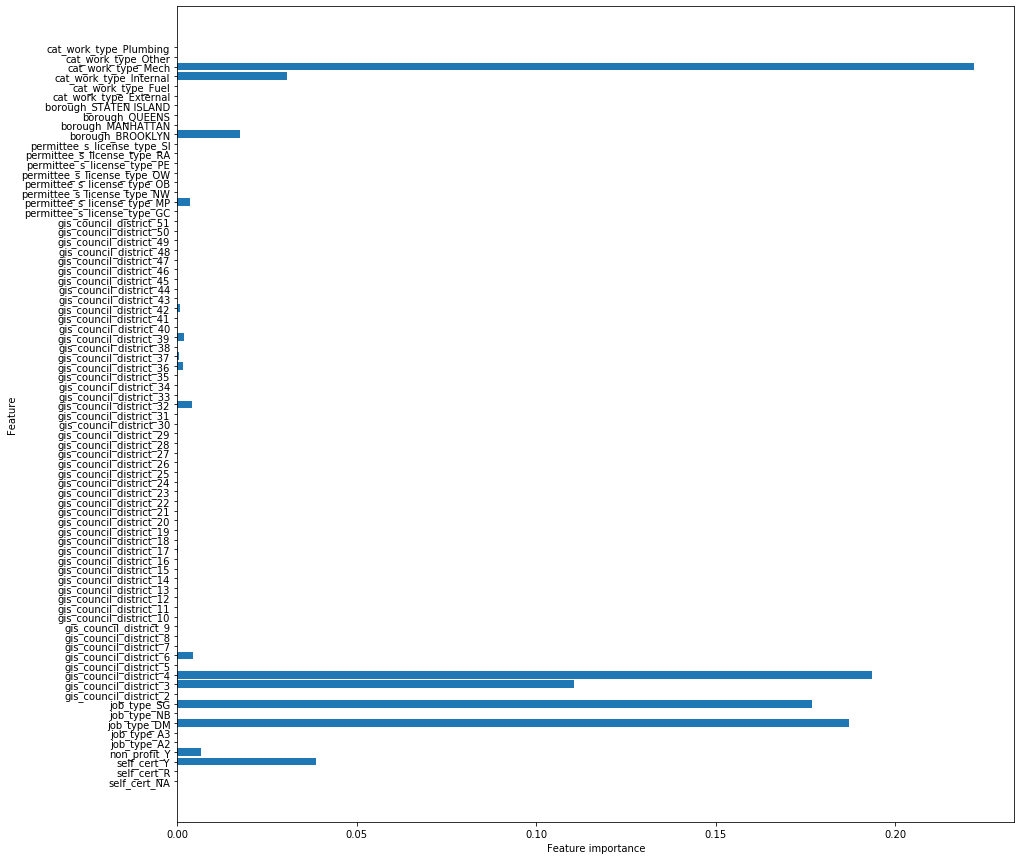

In [35]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
    n_features = X_train_ohe.shape[1]
    
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    
    plt.yticks(np.arange(n_features), col_names) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

Looks like the important features are:
- Individual Business type (DUH)
- Work type (mech, fuel, mech)
- City Council District 4 (midtown east, UES, Stytown)
- City Council District 3 (midtown west, Hudson Yards)
- Job Type - SG
- Job Type - A3
- Non Profit Yes (NYCHA?)
- Self Cert Yes (Landlords working on own buildings?)

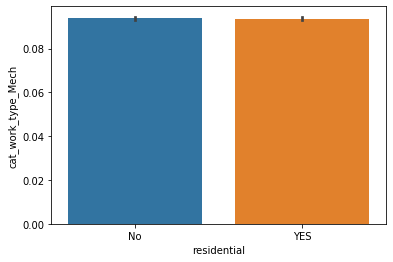

In [96]:
import seaborn as sns
sns.barplot(y ='cat_work_type_Mech', x = y, data=ohe_df)

**Confusion Matrix**

In [ ]:
#make X_test into a dataframe
#make Y_test into a dataframe

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction = clf.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

[[ 63458  91732]
 [ 23246 157280]]
              precision    recall  f1-score   support

          No       0.73      0.41      0.52    155190
         YES       0.63      0.87      0.73    180526

    accuracy                           0.66    335716
   macro avg       0.68      0.64      0.63    335716
weighted avg       0.68      0.66      0.64    335716



**Random Forest**

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

Bagging Trees:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- n_estimators = The number of base estimators in the ensemble.

In [42]:
bagging_trees = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [43]:
bagging_trees.fit(X_train_ohe, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [44]:
y_predict = clf.predict(X_test_ohe)
y_predict

array(['YES', 'YES', 'YES', ..., 'YES', 'YES', 'YES'], dtype=object)

In [45]:
# Training accuracy score
bagging_trees.score(X_train_ohe, y_train)

0.6600005659545568

In [46]:
# Test accuracy score
bagging_trees.score(X_test_ohe, y_test)

0.6585357862002407

Fit to Random Forest

In [47]:
# Instantiate and fit a RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
random_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
# Training accuracy score
random_forest.score(X_train_ohe, y_train)

0.6706859369228753

In [49]:
# Test accuracy score
random_forest.score(X_test_ohe, y_test)

0.66979530317292

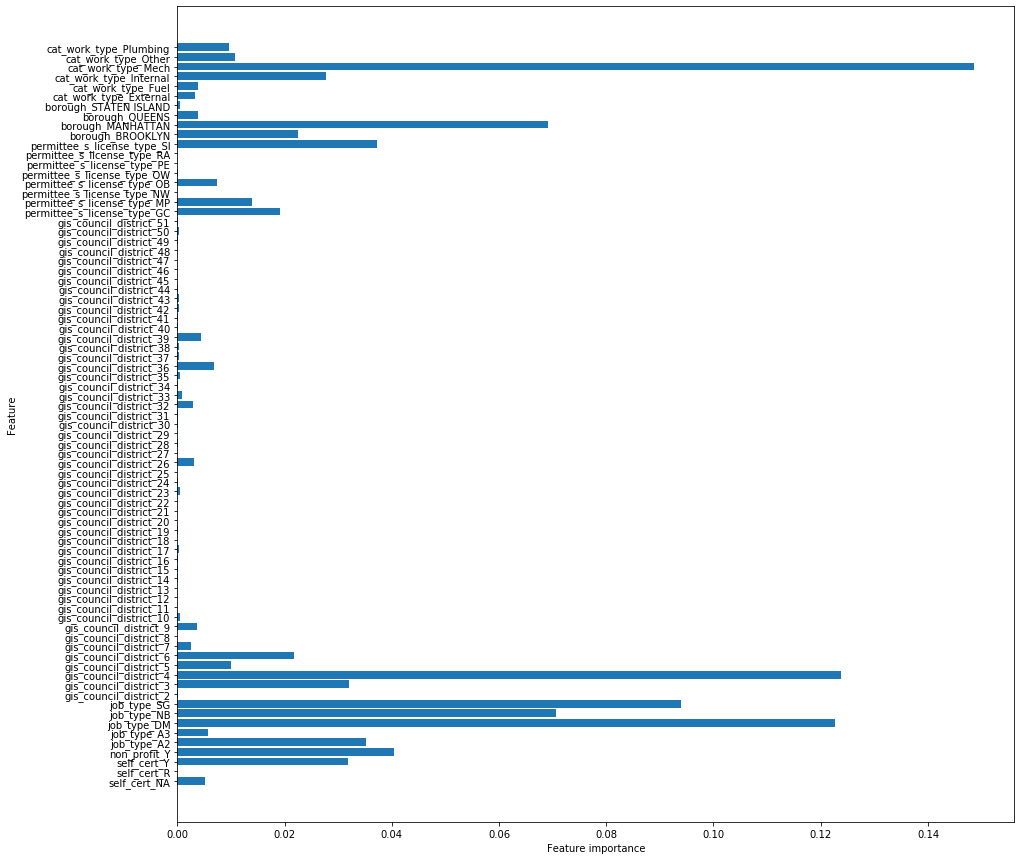

In [36]:

plot_feature_importances(random_forest)

Look at individual trees in the forest!

In [37]:
# Instantiate and fit a RandomForestClassifier
single_forest = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
single_forest.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
# First tree from the forest!
tree_one = single_forest.estimators_[0]

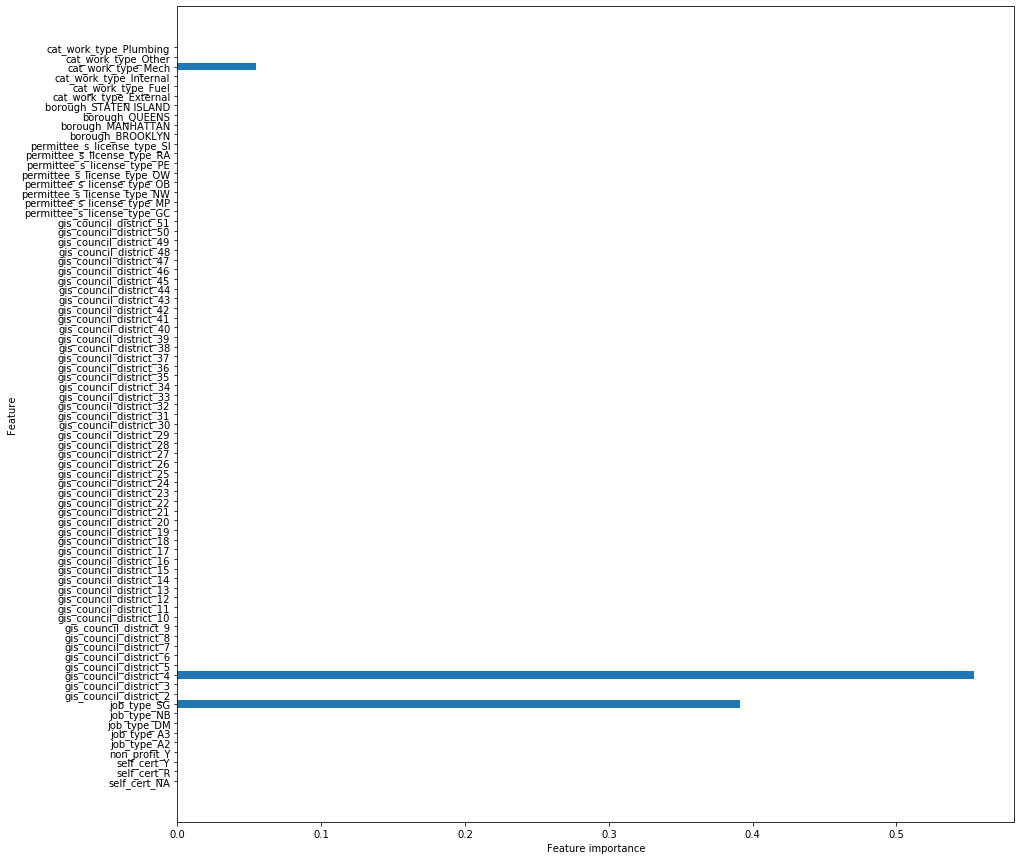

In [39]:
# Feature importance for this single tree
plot_feature_importances(tree_one)

In [40]:
# Second tree from forest
tree_two = single_forest.estimators_[1]

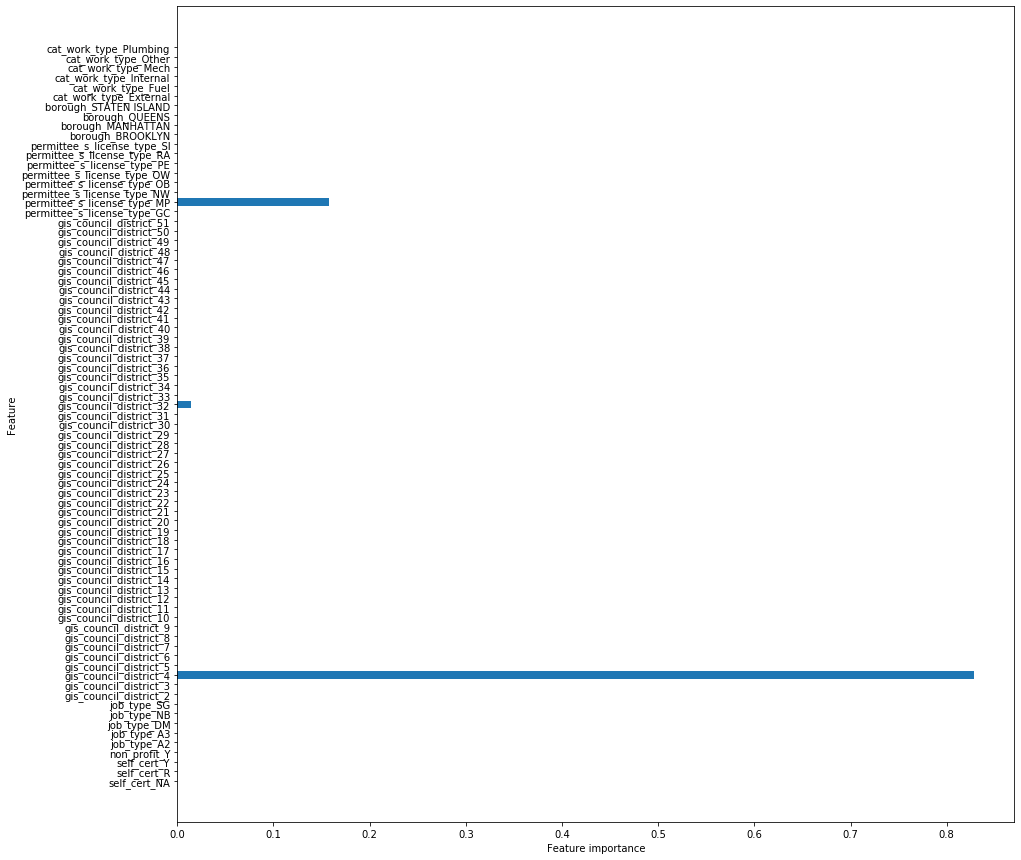

In [41]:
# Feature importance
plot_feature_importances(tree_two)

Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Test set predictions
prediction_forest = random_forest.predict(X_test_ohe)

# Confusion matrix and classification report
print(confusion_matrix(y_test, prediction_forest))
print(classification_report(y_test, prediction_forest))

[[ 69711  85479]
 [ 25376 155150]]
              precision    recall  f1-score   support

          No       0.73      0.45      0.56    155190
         YES       0.64      0.86      0.74    180526

    accuracy                           0.67    335716
   macro avg       0.69      0.65      0.65    335716
weighted avg       0.69      0.67      0.65    335716



In [58]:
!conda list scikit-learn

# packages in environment at /Users/melissamunz/anaconda3:
#
# Name                    Version                   Build  Channel
scikit-learn              0.21.2           py37h27c97d8_0  


**AdaBoost**

In [73]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [62]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=1)

In [64]:
adaboost_clf.fit(X_train_ohe, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [65]:
X_train_ohe.shape

(8000, 75)

In [66]:
X_test_ohe.shape

(2000, 75)

In [67]:
# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(X_train_ohe)
adaboost_test_preds = adaboost_clf.predict(X_test_ohe)

In [80]:
print(accuracy_score(y_train, adaboost_train_preds))
print(accuracy_score(y_test, adaboost_test_preds))

0.682625
0.6675


In [81]:
# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

In [82]:
gbt_clf.fit(X_train_ohe, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#product confusion matrix for AdaBoost
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

**SVM**

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split  
from time import time

tic = time()
svclassifier = SVC(kernel='rbf', C=1) 
#smaller C, bigger the budget. If too small C, high bias model.
#bigger C, smaller budget. High variance model.
#when svm doesnt work, try different kernals (rbf, linear, sigmoid, poly, etc)

svclassifier.fit(X_train_ohe, y_train) 
y_pred = svclassifier.predict(X_test_ohe)
toc = time()
print("run time is {} seconds".format(toc-tic))


/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


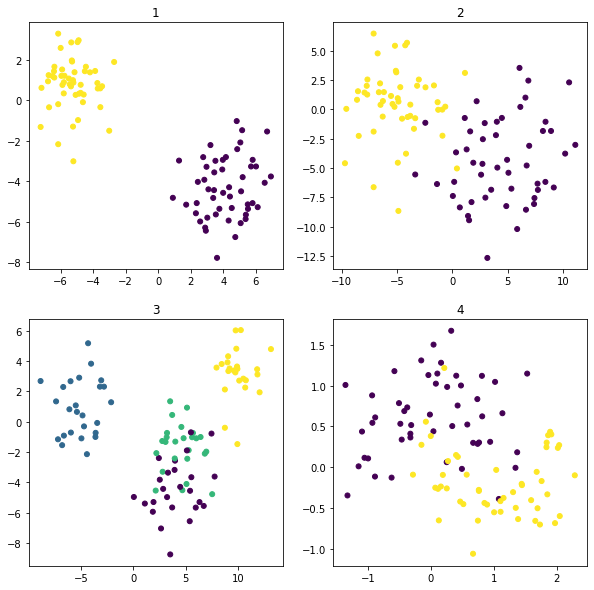

In [44]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title('1')
X_1, y_1 = make_blobs(n_features=2, centers=2, cluster_std=1.25, random_state=123)
plt.scatter(X_1[:, 0], X_1[:, 1], c = y_1, s=25)

plt.subplot(222)
plt.title('2')
X_2, y_2 = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=3,  random_state=123)
plt.scatter(X_2[:, 0], X_2[:, 1], c = y_2, s=25)

plt.subplot(223)
plt.title('3')
X_3, y_3 = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=1.6,  random_state=123)
plt.scatter(X_3[:, 0], X_3[:, 1], c=y_3, s=25)

plt.subplot(224)
plt.title('4')
X_4, y_4 = make_moons(n_samples=100, shuffle=False , noise=0.3, random_state=123)
plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, s=25)

plt.show()

In [ ]:
# Print the coefficients
clf.coef_

In [ ]:
#Save the first feature (on the horizontal axis) as X_11 
#Save the second feature (on the vertical axis) as X_12.
X_11= X_1[:, 0]
X_12= X_1[:, 1]